In [1]:
%matplotlib inline

from pymc3 import  *
import arviz as az

import numpy as np
import matplotlib.pyplot as plt


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Probabilistic Reformulation

Bayesians take a probabilistic view of the world and express this model in terms of probability distributions. Our above linear regression can be rewritten to yield:

Y∼N(Xβ,σ2)
In words, we view Y as a random variable (or random vector) of which each element (data point) is distributed according to a Normal distribution. The mean of this normal distribution is provided by our linear predictor with variance σ2.

While this is essentially the same model, there are two critical advantages of Bayesian estimation:

Priors: We can quantify any prior knowledge we might have by placing priors on the paramters. For example, if we think that σ is likely to be small we would choose a prior with more probability mass on low values.
Quantifying uncertainty: We do not get a single estimate of β as above but instead a complete posterior distribution about how likely different values of β are. For example, with few data points our uncertainty in β will be very high and we'd be getting very wide posteriors.

### Generating data

Create some toy data to play around with and scatter-plot it.

Essentially we are creating a regression line defined by intercept and slope and add data points by sampling from a Normal with the mean set to the regression line.

In [2]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

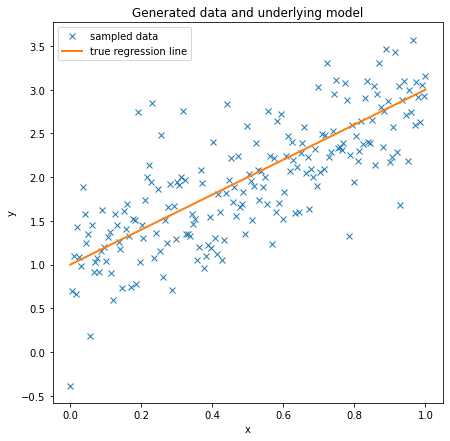

In [3]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

### Fitting Bayesian linear regression model

In [4]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sd=20)
    x_coeff = Normal('x', 0, sd=20)
    
    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x, 
                        sd=sigma, observed=y)
    
    # Inference!
    trace = sample() # draw posterior samples using NUTS sampling

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 36 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The acceptance probability does not match the target. It is 0.8832663473499075, but should be close to 0.8. Try to increase the number of tuning steps.


The new glm() function instead takes a Patsy linear model specifier from which it creates a design matrix. glm() then adds random variables for each of the coefficients and an appopriate likelihood to the model.

In [9]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    GLM.from_formula('y ~ x', data)
    trace = sample(chains=4) # draw posterior samples using NUTS sampling

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The acceptance probability does not match the target. It is 0.8812599485116273, but should be close to 0.8. Try to increase the number of tuning steps.


Much shorter, but this code does the exact same thing as the above model specification (you can change priors and everything else too if we wanted). glm() parses the Patsy model string, adds random variables for each regressor (Intercept and slope x in this case), adds a likelihood (by default, a Normal is chosen), and all other variables (sigma). Finally, glm() then initializes the parameters to a good starting point by estimating a frequentist linear model using statsmodels.

If you are not familiar with R's syntax, 'y ~ x' specifies that we have an output variable y that we want to estimate as a linear function of x.

### Analyzing the model

Bayesian inference does not give us only one best fitting line (as maximum likelihood does) but rather a whole posterior distribution of likely parameters. Lets plot the posterior distribution of our parameters and the individual samples we drew.

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
C:\Program Files\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

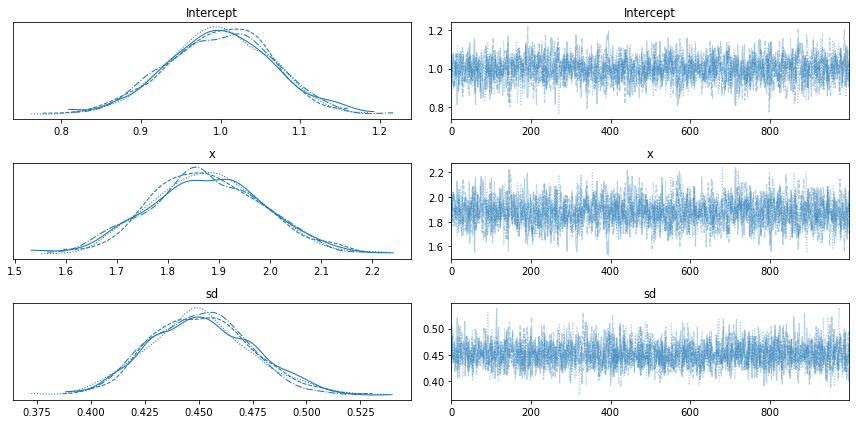

In [10]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout()
plt.show()

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs.

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns). We see 4 lines because we ran 4 chains in parallel (njobs parameter above). They all seem to provide the same answer which is re-assuring.`

Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (x is the regression coefficient and sigma is the standard deviation of our normal).

In the GLM we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. Here we are using the glm.plot_posterior_predictive() convenience function for this.

C:\Program Files\Anaconda\lib\site-packages\pymc3\plots\posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


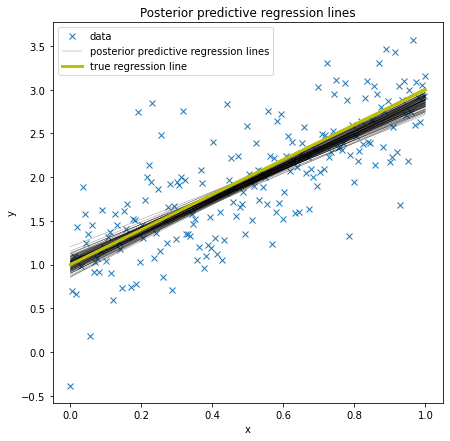

In [14]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plots.plot_posterior_predictive_glm(trace, samples=100, 
                                    label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

As you can see, our estimated regression lines are very similar to the true regression line. But since we only have limited data we have uncertainty in our estimates, here expressed by the variability of the lines.